In [2604]:
# Importing neccessary modules
import cv2
import matplotlib.pyplot as plt
import os
import pytesseract
import re
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

In [2605]:
# Define the paths to the image and template
image_path = './resources/slika4.jpg'
template_path = './templates/ZG-template.jpg'

# Check if the image file exists
if not os.path.exists(image_path):
    print(f"Image file not found at {image_path}")
else:
    print(f"Image file found at {image_path}")

# Check if the template file exists
if not os.path.exists(template_path):
    print(f"Template file not found at {template_path}")
else:
    print(f"Template file found at {template_path}")

Image file found at ./resources/slika4.jpg
Template file found at ./templates/ZG-template.jpg


In [2606]:
def show_images(image, template):
    fig = plt.figure()

    # Setting values to rows and column variables
    rows = 1
    columns = 2

    fig.add_subplot(rows, columns, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title("Image")
    fig.add_subplot(rows, columns, 2)
    plt.imshow(cv2.cvtColor(template, cv2.COLOR_BGR2RGB))
    plt.title("Template")

def show_grays(image, template):
    # Create figure
    fig = plt.figure()
    # Setting values to rows and column variables
    rows = 1
    columns = 2
    # Convert the image to grayscale
    fig.add_subplot(rows, columns, 1)
    plt.imshow(image, cmap='gray')
    plt.title("Gray image")
    fig.add_subplot(rows, columns, 2)
    plt.imshow(template, cmap='gray')
    plt.title("Gray template")

def set_gray(target):
    result = cv2.cvtColor(target, cv2.COLOR_BGR2GRAY)
    return result

def resize_needed(tmpl_height, img_height, tmpl_width, img_width):
    return tmpl_height > img_height or tmpl_width > img_width



Image loaded successfully.
Template loaded successfully.


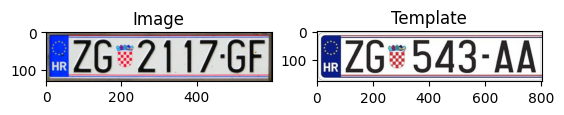

In [2607]:
# Load the image and template
image = cv2.imread(image_path)
template = cv2.imread(template_path)

if image is None:
    print("Failed to load image.")
else:
    print("Image loaded successfully.")

if template is None:
    print("Failed to load template.")
else:
    print("Template loaded successfully.")

show_images(image, template)

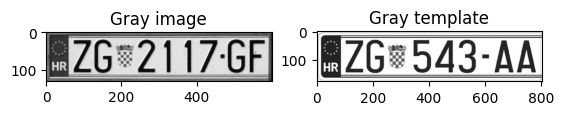

In [2608]:
gray_image = set_gray(image)
# Check if the conversion was successful
if gray_image is None:
    print("Error converting image to grayscale")
else:
    gray_template = set_gray(template)
    show_grays(gray_image, gray_template)

Image dimensions: 600x129
Template dimensions: 805x178
Resized template dimensions: 583x129
max_val = 0.3595932424068451


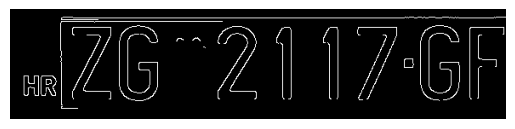

In [2609]:
# Check the dimensions of the images
img_height, img_width = gray_image.shape
tmpl_height, tmpl_width = gray_template.shape

print(f"Image dimensions: {img_width}x{img_height}")
print(f"Template dimensions: {tmpl_width}x{tmpl_height}")

# Resize the template if it is larger than the image
if resize_needed(tmpl_height, img_height, tmpl_width, img_width) is True:
    scale_factor = min(img_height / tmpl_height, img_width / tmpl_width)
    new_tmpl_height = int(tmpl_height * scale_factor)
    new_tmpl_width = int(tmpl_width * scale_factor)
    gray_template = cv2.resize(gray_template, (new_tmpl_width, new_tmpl_height))
    print(f"Resized template dimensions: {new_tmpl_width}x{new_tmpl_height}")

# Set a lower threshold for detection
threshold = 0.1

best_max_val = 0
best_kernel_size_image = (0, 0)
best_kernel_size_template = (0, 0)

# Iterate over a range of kernel sizes for both image and template
for k_img in range(1, 10, 2):  # Using odd numbers for kernel size
    for k_tmpl in range(1, 10, 2):  # Using odd numbers for kernel size
        blurred_gray_image = cv2.GaussianBlur(gray_image, (k_img, k_img), 0)
        blurred_gray_template = cv2.GaussianBlur(gray_template, (k_tmpl, k_tmpl), 0)

        # Perform template matching using grayscale images
        result = cv2.matchTemplate(blurred_gray_image, blurred_gray_template, cv2.TM_CCOEFF_NORMED)

        # Find the minimum and maximum correlation scores and their locations
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)

        if max_val > best_max_val:
            best_max_val = max_val
            best_kernel_size_image = (k_img, k_img)
            best_kernel_size_template = (k_tmpl, k_tmpl)
            best_match_loc = max_loc


if best_max_val >= threshold:
    # Apply the best kernel sizes to the images
    blurred_gray_image = cv2.GaussianBlur(gray_image, best_kernel_size_image, 0)
    blurred_gray_template = cv2.GaussianBlur(gray_template, best_kernel_size_template, 0)

    # Perform template matching using the best kernel sizes
    result = cv2.matchTemplate(blurred_gray_image, blurred_gray_template, cv2.TM_CCOEFF_NORMED)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)
    print(f"max_val = {max_val}")
    top_left = max_loc
    h, w = gray_template.shape
    bottom_right = (top_left[0] + w, top_left[1] + h)
    cv2.rectangle(image, top_left, bottom_right, (0, 255, 0), 2)

    # Extract the detected plate region
    detected_plate = gray_image[top_left[1]:bottom_right[1], top_left[0]:bottom_right[0]]

    # Apply edge detection
    edges = cv2.Canny(detected_plate, 525, 702)
    plt.axis('off')
    plt.imshow(edges, cmap='gray')
    plt.show()
else:
    print("No match found above the threshold.")

Raw detected plate text: wlZG2117-GF
Formatted plate text: ZG2117-GF



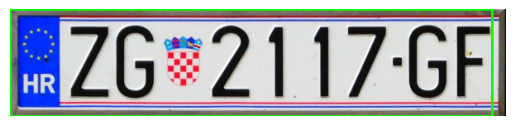

In [2610]:
# Use pytesseract to extract text from the detected plate region
plate_text = pytesseract.image_to_string(edges, config='--psm 8')  # PSM 8 is for single word/line
print(f"Raw detected plate text: {plate_text.strip()}")

# Post-process the OCR result to match the expected format
formatted_plate_text = re.sub(r'[^A-Z0-9\s\-.]', '', plate_text)

print(f"Formatted plate text: {formatted_plate_text}")
# Display the result using matplotlib
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()